# Búsqueda de hiperparámetros en regresión lineal

En este tutorial trabajaremos con los modelos de regresión lineal. En concreto construiremos modelos lineales aproximados por mínimos cuadrados, así como sus versiones en las que se incorporan las regularizaciones Ridge, Lasso y Elastic Net.

Como último veremos una regresión polinómica

In [2]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector


# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [3]:
def rmse(y_test, y_test_pred):
  """ Este es mi cálculo del error cuadrático medio """
  return np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

Cargamos los datos

In [4]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()

X = housing.data
y = housing.target

In [5]:
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [6]:
# Holdout para la evaluación del modelo. 33% de los datos disponibles para test
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33, random_state=42)

In [7]:
def pintaResultados (reg, n):
  plt.subplots(figsize=(30, 5))
  x = np.arange(y_test[:n].size)
  pred = reg.predict(X=X_test)
  plt.plot(x, y_test[:n], 'r.', x, pred[:n], 'g^')

# Regresión lineal por mínimos cuadrados

RMSE de regresión lineal: 0.7327814505957735


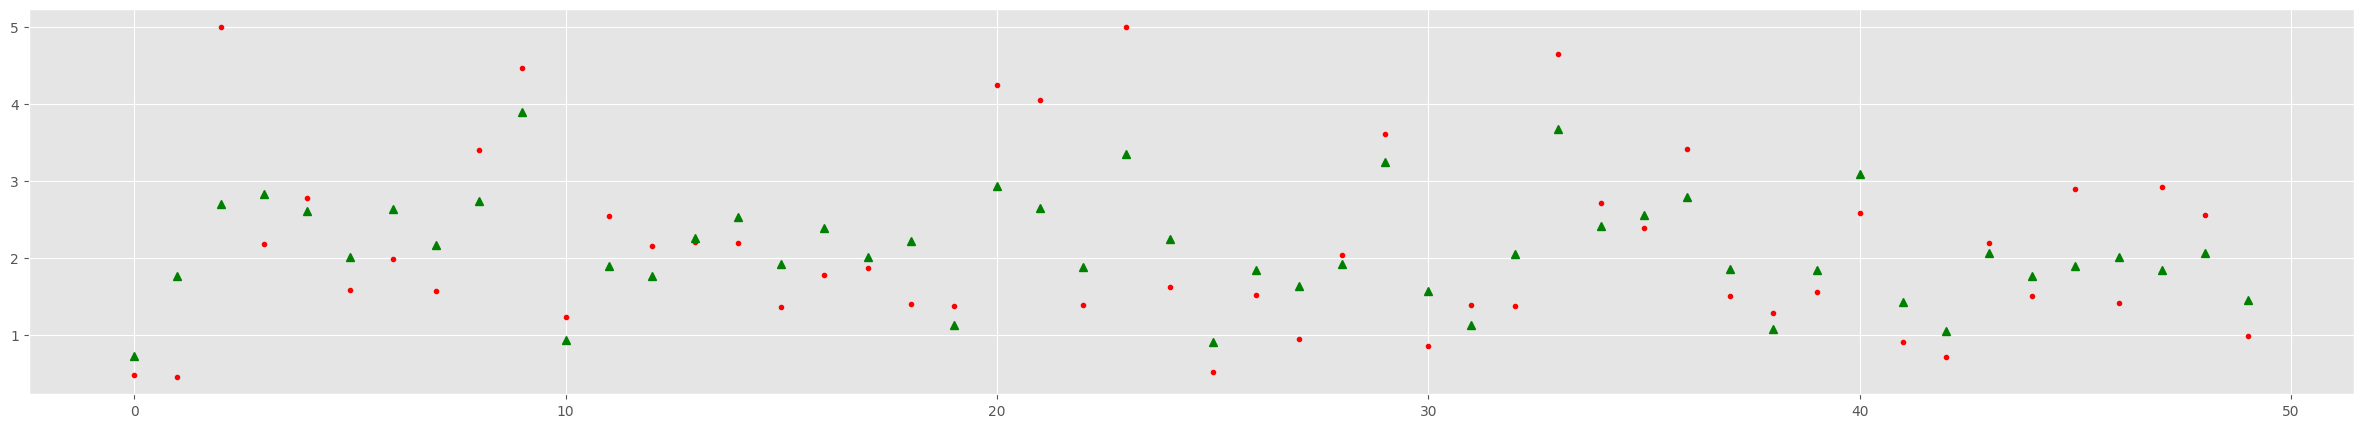

In [8]:
scaler = StandardScaler()
reg_lin = LinearRegression()

pipe_regr = Pipeline([
    ('scale', scaler),
    ('REGL', reg_lin)])

np.random.seed(42)
pipe_regr.fit(X=X_train, y=y_train)
print(f"RMSE de regresión lineal: {rmse(y_test, pipe_regr.predict(X=X_test))}")
pintaResultados(pipe_regr,50)

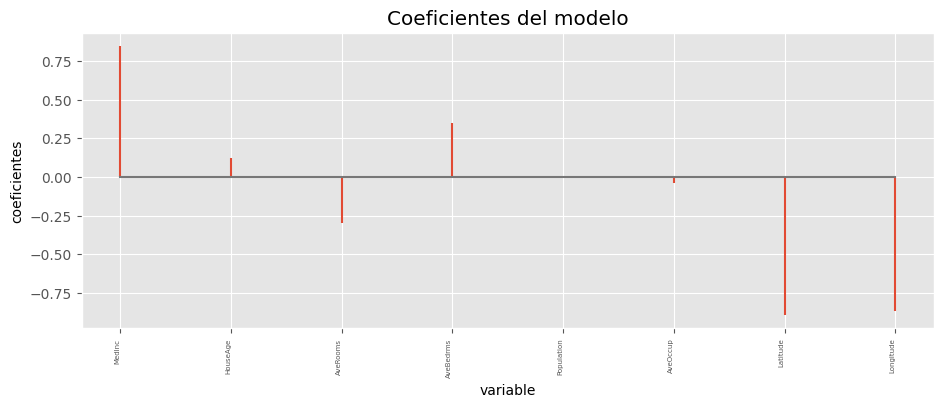

In [9]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': housing.feature_names,
                         'coef': pipe_regr['REGL'].coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');

# Ridge


RMSE de regresión lineal - Ridge: 0.7323062527610821


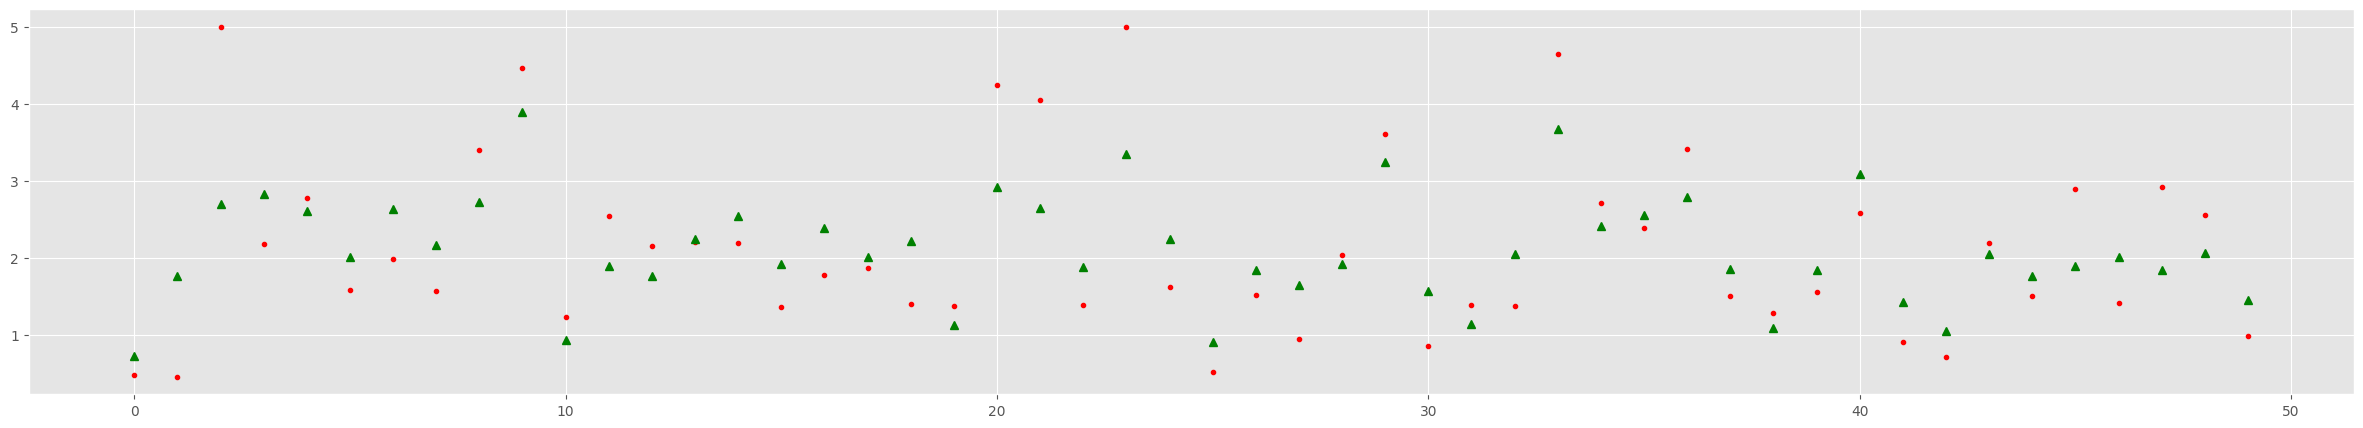

In [10]:
# Creación y entrenamiento del modelo (con búsqueda por CV del valor óptimo alpha)
# ==============================================================================
# Por defecto RidgeCV utiliza el mean squared error
regrRidge = RidgeCV(
            alphas          = np.logspace(-3, 8, 200),
            fit_intercept   = True,
            store_cv_values = True
         )

np.random.seed(42)
_ = regrRidge.fit(X = X_train, y = y_train)
print(f"RMSE de regresión lineal - Ridge: {rmse(y_test, regrRidge.predict(X=X_test))}")
pintaResultados(regrRidge,50)

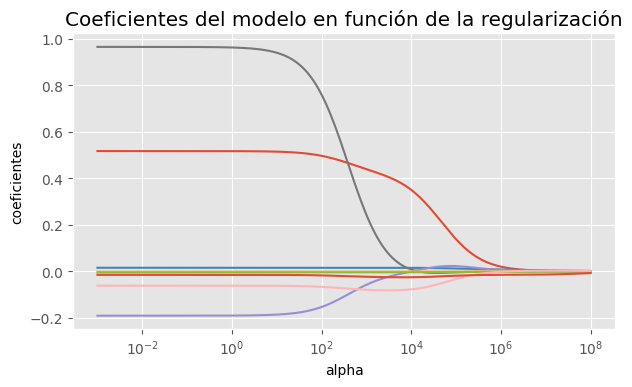

In [11]:
# Evolución de los coeficientes en función de alpha
# ==============================================================================
alphas = regrRidge.alphas
coefs = []

for alpha in alphas:
    modelo_temp = Ridge(alpha=alpha, fit_intercept=False)
    modelo_temp.fit(X_train, y_train)
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo en función de la regularización');
plt.axis('tight')
plt.show()

Como vemos, a medida que aumenta el valor de alpha, la regularización es mayor y el valor de los coeficientes se reduce

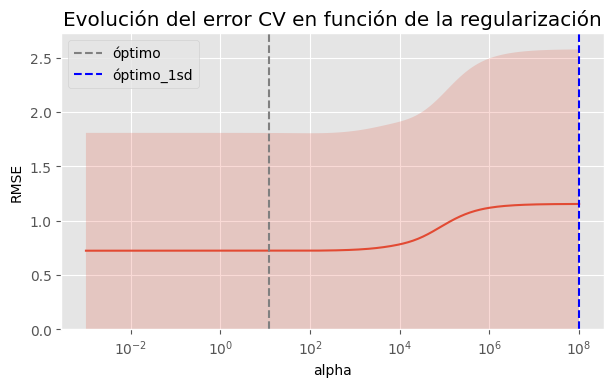

In [12]:
# Evolución del error en función de alpha
# ==============================================================================
# modelo.cv_values almacena el mse de cv para cada valor de alpha. Tiene
# dimensiones (n_samples, n_targets, n_alphas)
mse_cv = regrRidge.cv_values_.reshape((-1, 200)).mean(axis=0)
mse_sd = regrRidge.cv_values_.reshape((-1, 200)).std(axis=0)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)
rmse_sd = np.sqrt(mse_sd)

# Se identifica el óptimo y el óptimo + 1std
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = regrRidge.alphas[np.argmin(rmse_cv)]
optimo_1sd   = regrRidge.alphas[rmse_cv == min_rsme_1sd]


# Gráfico del error +- 1 desviación estándar
fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(regrRidge.alphas, rmse_cv)
ax.fill_between(
    regrRidge.alphas,
    rmse_cv + rmse_sd,
    rmse_cv - rmse_sd,
    alpha=0.2
)

ax.axvline(
    x         = optimo,
    c         = "gray",
    linestyle = '--',
    label     = 'óptimo'
)

ax.axvline(
    x         = optimo_1sd,
    c         = "blue",
    linestyle = '--',
    label     = 'óptimo_1sd'
)
ax.set_xscale('log')
ax.set_ylim([0,None])
ax.set_title('Evolución del error CV en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend();

In [13]:
# Mejor valor alpha encontrado
# ==============================================================================
print(f"Mejor valor de alpha encontrado: {regrRidge.alpha_}")

Mejor valor de alpha encontrado: 12.315506032928262


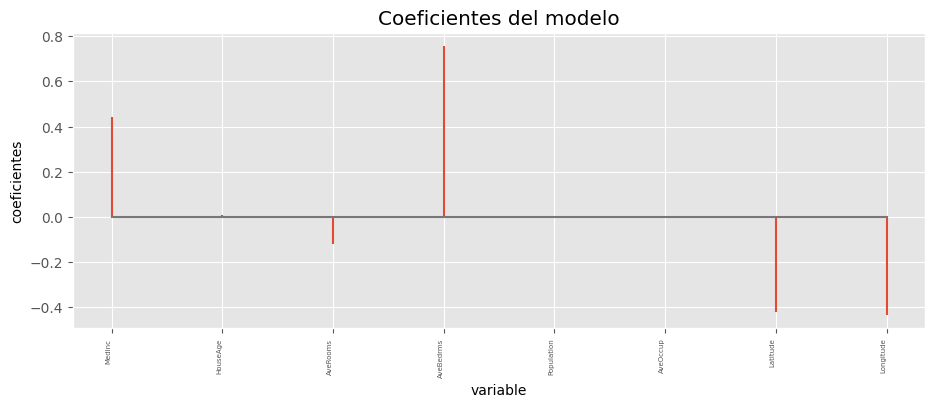

In [14]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': housing.feature_names,
                         'coef': regrRidge.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');

En comparación al modelo por mínimos cuadrados ordinarios, con ridge, el orden de magnitud de los coeficientes es menor.

# Lasso

RMSE de regresión lineal: 0.73246054205434


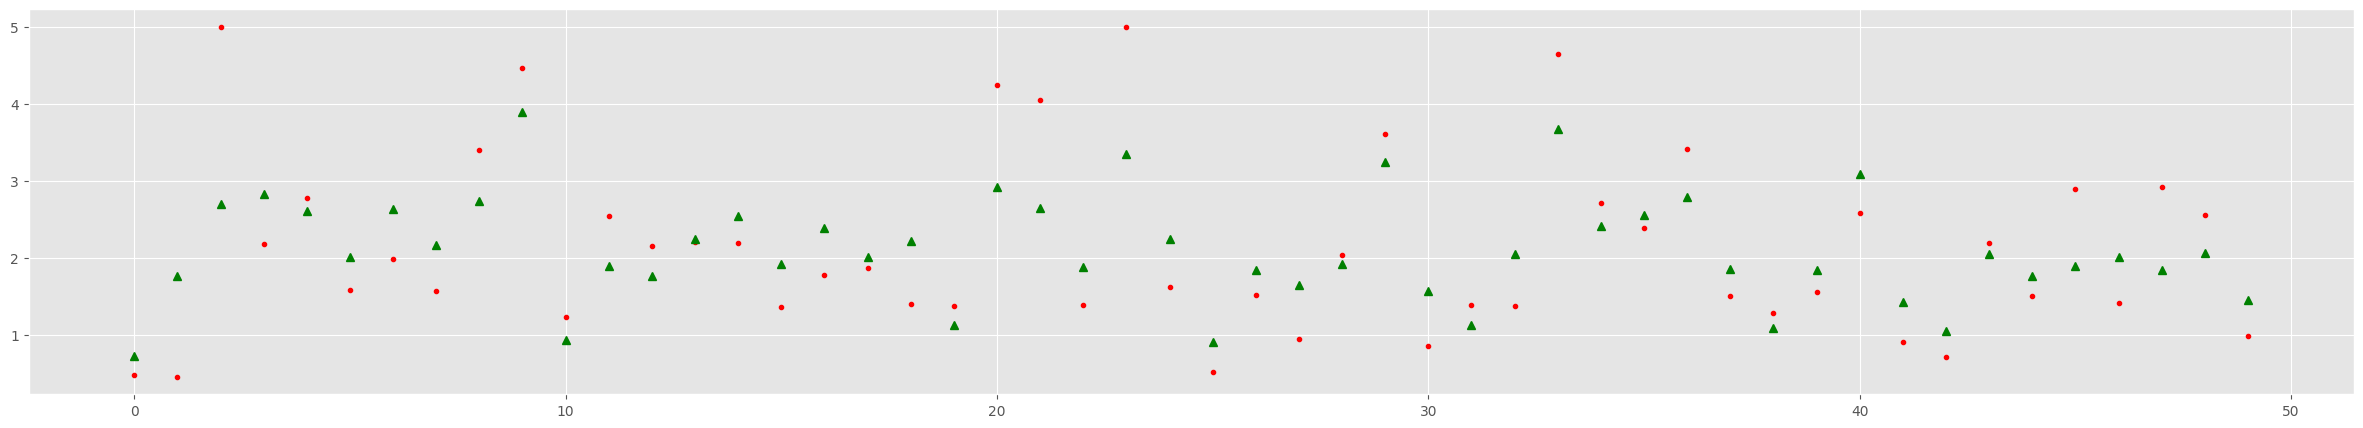

In [15]:
# Creación y entrenamiento del modelo (con búsqueda por CV del valor óptimo alpha)
# ==============================================================================
# Por defecto LassoCV utiliza el mean squared error
regrLasso = LassoCV(
            alphas          = np.logspace(-9, 3, 200),
            cv              = 10
         )

np.random.seed(42)
_ = regrLasso.fit(X = X_train, y = y_train)
print(f"RMSE de regresión lineal: {rmse(y_test, regrLasso.predict(X=X_test))}")
pintaResultados(regrLasso,50)

In [16]:
# Evolución de los coeficientes en función de alpha
# ==============================================================================
alphas = regrLasso.alphas_
coefs = []

for alpha in alphas:
    modelo_temp = Lasso(alpha=alpha, fit_intercept=False)
    modelo_temp.fit(X_train, y_train)
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_ylim([-1,None])
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo en función de la regularización');

KeyboardInterrupt: 

Puede ver se como, a medida que aumenta el valor de alpha, la regularización es mayor y más predictores quedan excluidos (su coeficiente es 0).

In [ ]:
# Número de predictores incluidos (coeficiente !=0) en función de alpha
# ==============================================================================
alphas = regrLasso.alphas_
n_predictores = []

for alpha in alphas:
    modelo_temp = Lasso(alpha=alpha, fit_intercept=False)
    modelo_temp.fit(X_train, y_train)
    coef_no_cero = np.sum(modelo_temp.coef_.flatten() != 0)
    n_predictores.append(coef_no_cero)

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, n_predictores)
ax.set_xscale('log')
ax.set_ylim([-1,None])
ax.set_xlabel('alpha')
ax.set_ylabel('nº predictores')
ax.set_title('Predictores incluidos en función de la regularización');

In [ ]:
# Evolución del error en función de alpha
# ==============================================================================
# regrLasso.mse_path_ almacena el mse de cv para cada valor de alpha. Tiene
# dimensiones (n_alphas, n_folds)
mse_cv = regrLasso.mse_path_.mean(axis=1)
mse_sd = regrLasso.mse_path_.std(axis=1)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)
rmse_sd = np.sqrt(mse_sd)

# Se identifica el óptimo y el óptimo + 1std
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = regrLasso.alphas_[np.argmin(rmse_cv)]
optimo_1sd   = regrLasso.alphas_[rmse_cv == min_rsme_1sd]

# Gráfico del error +- 1 desviación estándar
fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(regrLasso.alphas_, rmse_cv)
ax.fill_between(
    regrLasso.alphas_,
    rmse_cv + rmse_sd,
    rmse_cv - rmse_sd,
    alpha=0.2
)

ax.axvline(
    x         = optimo,
    c         = "gray",
    linestyle = '--',
    label     = 'óptimo'
)

ax.axvline(
    x         = optimo_1sd,
    c         = "blue",
    linestyle = '--',
    label     = 'óptimo_1sd'
)

ax.set_xscale('log')
ax.set_ylim([0,None])
ax.set_title('Evolución del error CV en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend();


In [ ]:
# Mejor valor alpha encontrado
# ==============================================================================
print(f"Mejor valor de alpha encontrado: {regrLasso.alpha_}")

In [ ]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': housing.feature_names,
                         'coef': regrLasso.coef_.flatten()}
                  )
fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');

Comprobar como sólo se utilizan, básicamente, seis predictores.

# Elastic Net

RMSE de regresión lineal: 0.7323312734039618


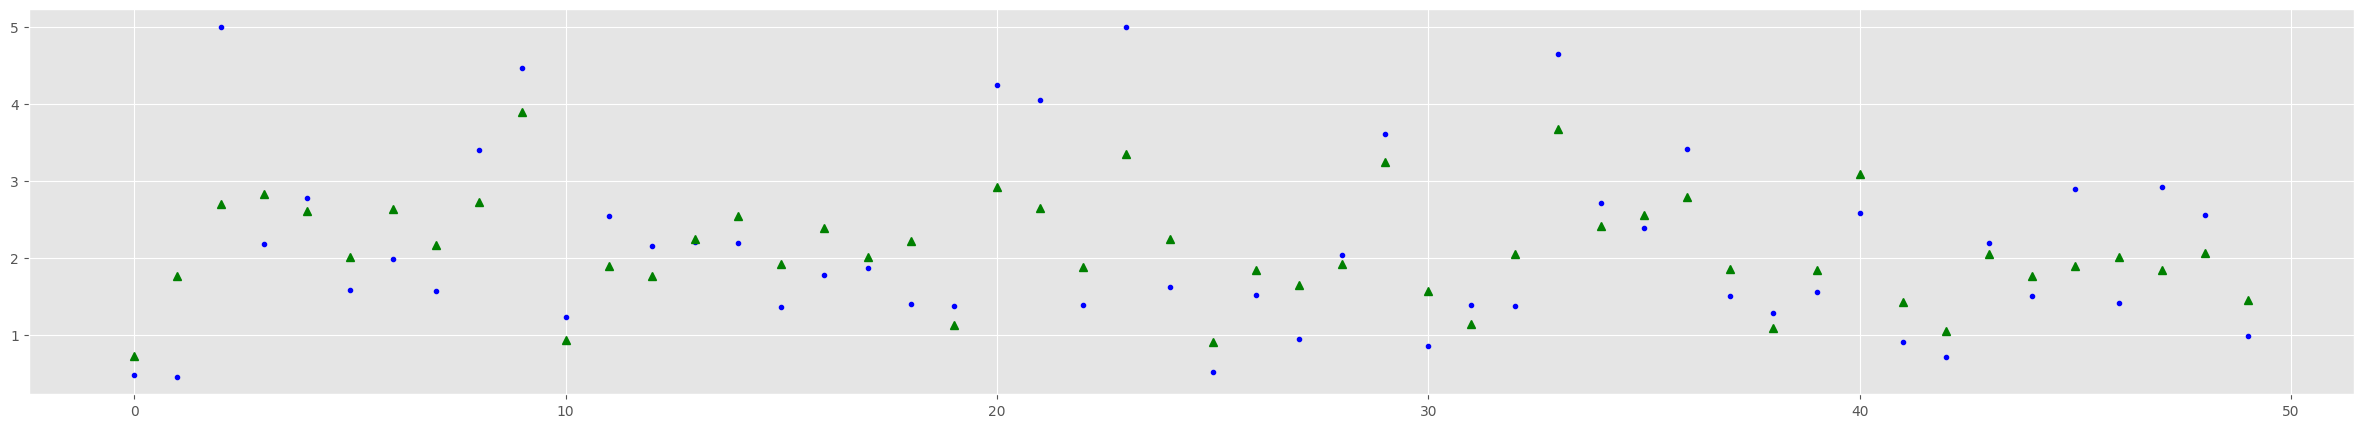

In [ ]:
# ==============================================================================
# Por defecto ElasticNetCV utiliza el mean squared error
regrElastic = ElasticNetCV(
            l1_ratio        = [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99],
            alphas          = np.logspace(-10, 3, 200),
            cv              = 10
         )
np.random.seed(42)
_ = regrElastic.fit(X = X_train, y = y_train)
print(f"RMSE de regresión lineal: {rmse(y_test, regrElastic.predict(X=X_test))}")
pintaResultados(regrElastic,50)

In [ ]:
# Evolución del error en función de alpha y l1_ratio
# ==============================================================================
# regrElastic.mse_path_ almacena el mse de cv para cada valor de alpha y l1_ratio.
# Tiene dimensiones (n_l1_ratio, n_alpha, n_folds)

# Error medio de las 10 particiones por cada valor de alpha y l1_ratio 
mean_error_cv = regrElastic.mse_path_.mean(axis =2)

# El resultado es un array de dimensiones (n_l1_ratio, n_alpha)
# Se convierte en un dataframe
df_resultados_cv = pd.DataFrame(
                        data   = mean_error_cv.flatten(),
                        index  = pd.MultiIndex.from_product(
                                    iterables = [regrElastic.l1_ratio, regrElastic.alphas_],
                                    names     = ['l1_ratio', 'modelo.alphas_']
                                 ),
                        columns = ["mse_cv"]
                    )

df_resultados_cv['rmse_cv'] = np.sqrt(df_resultados_cv['mse_cv'])
df_resultados_cv = df_resultados_cv.reset_index().sort_values('mse_cv', ascending = True)
df_resultados_cv

,l1_ratio,modelo.alphas_,mse_cv,rmse_cv
93,0.0,0.000841,0.522173,0.722615
94,0.0,0.000723,0.522173,0.722615
92,0.0,0.000977,0.522173,0.722616
95,0.0,0.000622,0.522174,0.722616
294,0.1,0.000723,0.522174,0.722616
...,...,...,...,...
412,0.5,164.467618,1.331163,1.153760
413,0.5,141.499130,1.331163,1.153760
414,0.5,121.738273,1.331163,1.153760
408,0.5,300.183581,1.331163,1.153760


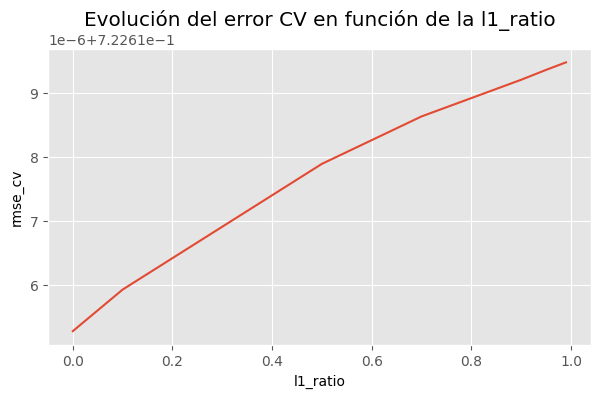

In [ ]:
# Mejor valor encontrado para cada l1_ratio
fig, ax = plt.subplots(figsize=(7, 3.84))
df_resultados_cv.groupby('l1_ratio')['rmse_cv'].min().plot(ax = ax)
ax.set_title('Evolución del error CV en función de la l1_ratio')
ax.set_xlabel('l1_ratio')
ax.set_ylabel('rmse_cv');

In [ ]:
# Mejor valor alpha y l1_ratio_ encontrado
# ==============================================================================
print(f"Mejor valor de alpha encontrado: {regrElastic.alpha_}")
print(f"Mejor valor de l1_ratio encontrado: {regrElastic.l1_ratio_}")

Mejor valor de alpha encontrado: 0.0008406652885618334
Mejor valor de l1_ratio encontrado: 0.0


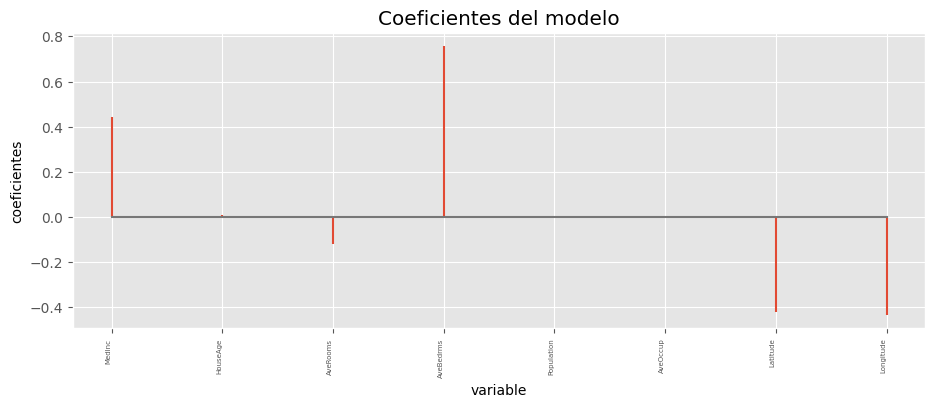

In [ ]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': housing.feature_names,
                         'coef': regrElastic.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');


# Comparamos

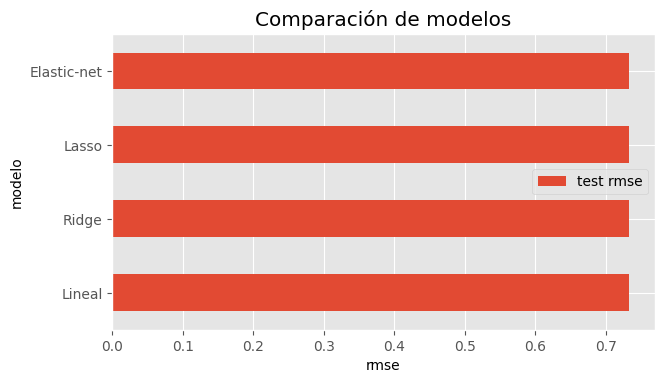

In [ ]:
rmse_lineal = rmse(y_test, pipe_regr.predict(X=X_test))
rmse_ridge = rmse(y_test, regrRidge.predict(X=X_test))
rmse_lasso = rmse(y_test, regrLasso.predict(X=X_test))
rmse_elastic = rmse(y_test, regrElastic.predict(X=X_test))
df_comparacion = pd.DataFrame({
                    'modelo': ['Lineal', 'Ridge', 'Lasso', 'Elastic-net'],
                    'test rmse': [rmse_lineal, rmse_ridge, rmse_lasso, rmse_elastic]
                 })

fig, ax = plt.subplots(figsize=(7, 3.84))
df_comparacion.set_index('modelo').plot(kind='barh', ax=ax)
ax.set_xlabel('rmse')
ax.set_ylabel('modelo')
ax.set_title('Comparación de modelos');

En este problema no hay mucha diferencia entre el modelo lineal y los modelos regularizados en cuanto al rmse. Sin embargo, como hemos visto, el número de predictores en los modelos es menor. Vamos a seleccionar aquellos coeficientes con un valor significativo (>0.5)

In [1]:
# Coeficientes de los distintos modelos
# ==============================================================================
d = [["Lineal", np.count_nonzero(np.abs(reg_lin.coef_.flatten()) > 0.5)],
     ["Ridge", np.count_nonzero(np.abs(regrRidge.coef_.flatten()) > 0.5)],
     ["Lasso", np.count_nonzero(np.abs(regrLasso.coef_.flatten()) > 0.5)],
     ["Elastic Net", np.count_nonzero(np.abs(regrElastic.coef_.flatten()) > 0.5)]]

df = pd.DataFrame(d, columns = ['Modelo','Núm. predictores'])
print(df)


NameError: name 'np' is not defined

# Regresión polinómica
Pasemos ahora a intentar una regresión polinómica. Haremos una búsqueda de los mejores hiperparámetros:
- 'grades': Grado del polinomio [2,3,4,5,6]

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score 

degrees = [2, 3, 4, 5, 6] # Change degree "hyperparameter" here
best_score = 0
best_degree = 0
for degree in degrees:
    poly_features = PolynomialFeatures(degree = degree, include_bias=False)
    X_train_poly = poly_features.fit_transform(X_train)
    polynomial_regressor = LinearRegression()
    polynomial_regressor.fit(X_train_poly, y_train)
    scores = cross_val_score(polynomial_regressor, X_train_poly, y_train, cv=3) # Change k-fold cv value here
    if max(scores) > best_score:
      best_score = max(scores)
      best_degree = degree     

NameError: name 'X_train' is not defined

In [ ]:
print(f"Mejor valor (R2): {best_score}")
print(f"Mejor valor de grado encontrado: {best_degree}")

Mejor valor (R2): 0.19758891665156086
Mejor valor de grado encontrado: 2


Creamos el modelo polinomial con los mejores parámetros:

RMSE de regresión polinomial: 0.6740253047260065


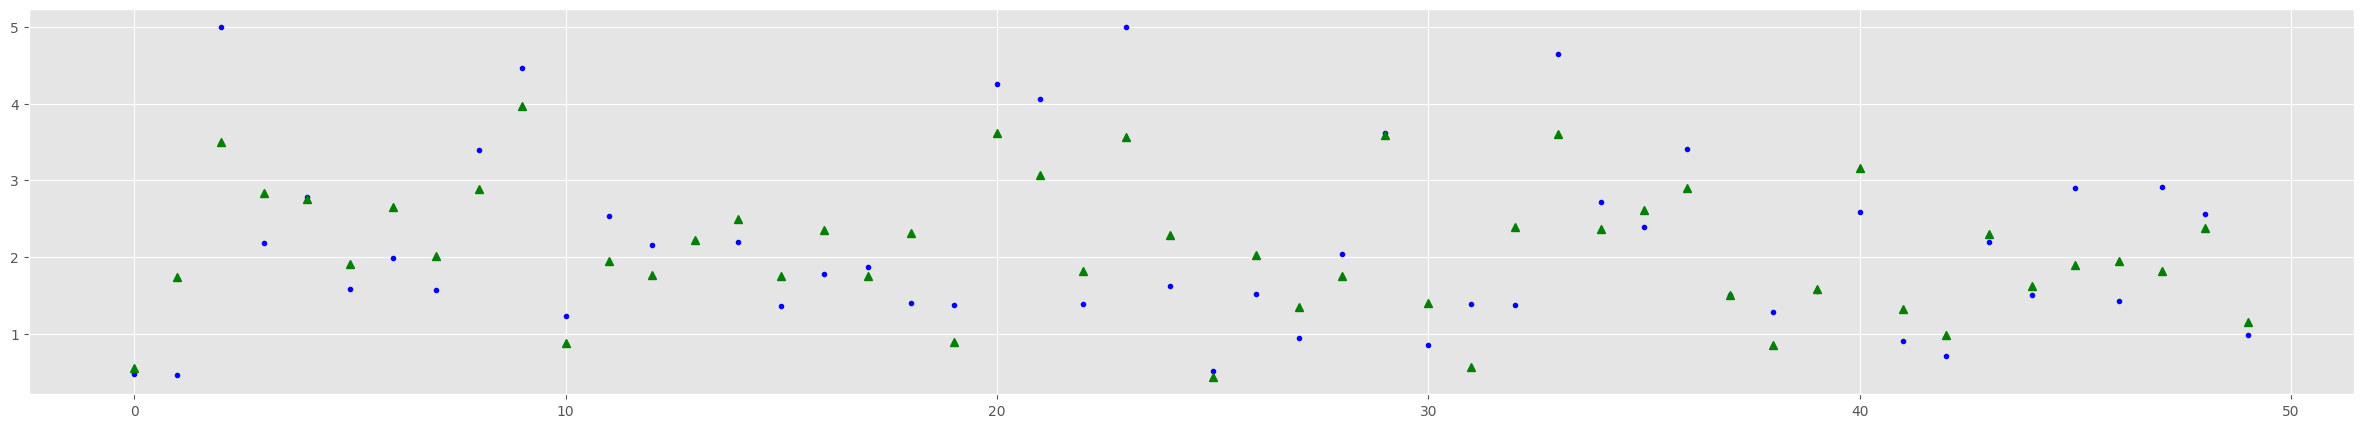

In [ ]:
poly_features = PolynomialFeatures(degree = best_degree, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
best_polynomial_regressor = LinearRegression()
best_polynomial_regressor.fit(X_train_poly, y_train)
X_test_poly = poly_features.fit_transform(X_test)
print(f"RMSE de regresión polinomial: {rmse(y_test, best_polynomial_regressor.predict(X=X_test_poly))}")
plt.subplots(figsize=(30, 5))
x = np.arange(y_test[:50].size)
y_pred = best_polynomial_regressor.predict(X=X_test_poly)
plt.plot(x, y_test[:50], 'b.', x, y_pred[:50], 'g^')


In [ ]:
print(best_polynomial_regressor.coef_)

[-1.15414106e+01 -8.11862950e-01  7.40435661e+00 -3.62804966e+01
 -3.51337442e-04  1.07533002e+00  8.64438332e+00  6.38606064e+00
 -3.31276792e-02  1.74393188e-03  4.49188697e-02 -1.49148481e-01
  4.68578617e-05 -4.41047528e-03 -1.61940837e-01 -1.49512666e-01
  2.34287292e-04 -9.19086849e-04  1.30407118e-02  2.57192355e-06
 -1.51084340e-03 -9.93986998e-03 -9.60253773e-03  1.40342650e-02
 -1.37151257e-01 -5.14965129e-05  2.08502024e-02  1.06092553e-01
  9.61066299e-02  3.33401116e-01  4.57830816e-04 -9.64070818e-02
 -5.36073278e-01 -4.72527897e-01  1.27413524e-09  2.34875437e-05
  1.02662788e-05  4.44296927e-06  4.96216717e-05  2.03496385e-02
  1.61337786e-02  5.91750416e-02  1.05430865e-01  4.15147685e-02]
